In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
using ForwardDiff

In [2]:
FPATH = "../../data/sampling_results/Benchmark-10/"

function marg_mean_shaped(name)
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp = mean(smpl_tmp)
    return smpl_tmp
end

function marg_std_shaped(name)
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp = std(smpl_tmp)
    return smpl_tmp
end

function get_emmitance(name, proj)
    # proj  1 / 2 
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp, smpl_w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    emm = smpl_tmp[proj,:].*smpl_tmp[2+proj,:].*10^-5 .* 1000 .* 426.0
    μ = mean(emm, FrequencyWeights(smpl_w))
    σ = std(emm, FrequencyWeights(smpl_w)) 
    return (mean = μ, std = σ)
end

get_emmitance (generic function with 1 method)

In [3]:
β1 = 0.015
β2 = 0.0077
β3 = 0.0058

# flat prior for the pixel size
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.20), truncated(Normal(0.2, 0.04), 0.03, 0.20)],
        ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 7.0), truncated(Normal(4.0, 2.0), 2.0, 7.0)],
        waist = [Normal(2.9, 0.03)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1.0, 1.0, 1.0], 
        resy = [1.0, 1.0, 1.0], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );


In [4]:
smpl_tmp = bat_read(FPATH*"hc-124.hdf5")
smpl_tmp = varshape(prior).(smpl_tmp);

In [5]:
filenames = readdir("../../data/sampling_results/Benchmark-10/")
images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
hc_mask = [i[1:3] == "hc-" for i in filenames]
hc_fnames = filenames[hc_mask]
hc_eind = parse.(Int64, [i[4:end-5] for i in hc_fnames])
hc_charge = images["charge"][hc_eind]
hc_runind = images["ev_ind"][hc_eind];

In [6]:
filenames = readdir("../../data/sampling_results/Benchmark-10/")
images = load("../../data/experiment/dataset_2/m1/images-satur.jld2")
lc_mask = [i[1:3] == "lc-" for i in filenames]
lc_fnames = filenames[lc_mask]
lc_eind = parse.(Int64, [i[4:end-5] for i in lc_fnames])
lc_charge = images["charge"][lc_eind]
lc_runind = images["ev_ind"][lc_eind];

In [7]:
fnames = [lc_fnames; hc_fnames]
charges = Float64[lc_charge; hc_charge]
runind = Int64[lc_runind ; hc_runind]
charges_n = charges ./ maximum(charges)
runind_n = runind ./ maximum(runind);

In [8]:
mean_params =  [marg_mean_shaped(i) for i in fnames];
std_params =  [marg_std_shaped(i) for i in fnames];

In [10]:
length(fnames)

241

### Alignment: 

In [11]:
# fnames[sortperm(Float64[i.tr_size[1] for i in std_params], rev=true)]

In [12]:
zc_x = [minimum([i.algmx[j] for i in mean_params]) for j in 1:4]; # find min position at each camera 
zc_y = [minimum([i.algmy[j] for i in mean_params]) for j in 1:4]; # find min position at each camera 

In [13]:
x_event = Array{Float64,1}[]
y_event = Array{Float64,1}[]
x_event_std = Array{Float64,1}[]
y_event_std = Array{Float64,1}[]

for i in eachindex(mean_params) 
    push!(x_event, (mean_params[i].algmx .- zc_x) .* [mean_params[i].psx ; mean_params[i].cam4_psx] .+ 1.0 )
    push!(y_event, (mean_params[i].algmy .- zc_y) .* [mean_params[i].psy ; mean_params[i].cam4_psy] .+ 1.0 )
    
    push!(x_event_std, std_params[i].algmx .* [mean_params[i].psx ; mean_params[i].cam4_psx])
    push!(y_event_std, std_params[i].algmy .* [mean_params[i].psy ; mean_params[i].cam4_psy])
     
end

### Emittance: 

In [14]:
emm_tmp_1 = [get_emmitance(i, 1) for i in fnames]
emm_tmp_2 = [get_emmitance(i, 2) for i in fnames];

### Summary File: 

In [15]:
summary_data = (
    
    ev_index = runind,
    ev_charge = charges,
    mode = [i > 15 ? "LP" : "SP" for i in charges],
    
    μx_trsz = Float64[i.tr_size[1] for i in mean_params],
    μy_trsz = Float64[i.tr_size[2] for i in mean_params],
    
    μx_angspr = Float64[i.ang_spr[1] for i in mean_params],
    μy_angspr = Float64[i.ang_spr[2] for i in mean_params],
    
    μ_waist = Float64[i.waist[1] for i in mean_params],

    μx_emitt = Float64[i.mean for i in emm_tmp_1],
    μy_emitt = Float64[i.mean for i in emm_tmp_2],
    
    μx_align = x_event,
    μy_align = y_event,
    
    σx_trsz = Float64[i.tr_size[1] for i in std_params],
    σy_trsz = Float64[i.tr_size[2] for i in std_params],
    
    σx_angspr = Float64[i.ang_spr[1] for i in std_params],
    σy_angspr = Float64[i.ang_spr[2] for i in std_params],
        
    σ_waist = Float64[i.waist[1] for i in std_params],
    
    σx_emitt = Float64[i.std for i in emm_tmp_1],
    σy_emitt = Float64[i.std for i in emm_tmp_2],
    
    σx_align = x_event_std,
    σy_align = y_event_std,
);



# Mean event SP:

In [16]:
mask_tmp = summary_data.mode .== "SP"

mean_event_sp = (
    ev_charge = [mean(summary_data.ev_charge[mask_tmp])],
    
    μx_trsz = [mean(summary_data.μx_trsz[mask_tmp])],
    μy_trsz = [mean(summary_data.μy_trsz[mask_tmp])],
    
    μx_angspr = [mean(summary_data.μx_angspr[mask_tmp])],
    μy_angspr = [mean(summary_data.μy_angspr[mask_tmp])],
    
    μ_waist = [mean(summary_data.μ_waist[mask_tmp])],

    μx_emitt = [mean(summary_data.μx_emitt[mask_tmp])],
    μy_emitt = [mean(summary_data.μy_emitt[mask_tmp])],
    
    μx_align = [mean(summary_data.μx_align[mask_tmp], )],
    μy_align = [mean(summary_data.μy_align[mask_tmp], )],
    
    σx_trsz = [mean(summary_data.σx_trsz[mask_tmp])],
    σy_trsz = [mean(summary_data.σy_trsz[mask_tmp])],
    
    σx_angspr = [mean(summary_data.σx_angspr[mask_tmp])],
    σy_angspr = [mean(summary_data.σy_angspr[mask_tmp])],
    
    σ_waist = [mean(summary_data.σ_waist[mask_tmp])],
    
    σx_emitt = [mean(summary_data.σx_emitt[mask_tmp])],
    σy_emitt = [mean(summary_data.σy_emitt[mask_tmp])],
    
    σx_align = [mean(summary_data.σx_align[mask_tmp])],
    σy_align = [mean(summary_data.σy_align[mask_tmp])],
);

# Mean event LP:

In [17]:
mask_tmp = summary_data.mode .== "LP"

mean_event_lp = (
    ev_charge = [mean(summary_data.ev_charge[mask_tmp])],
    
    μx_trsz = [mean(summary_data.μx_trsz[mask_tmp])],
    μy_trsz = [mean(summary_data.μy_trsz[mask_tmp])],
    
    μx_angspr = [mean(summary_data.μx_angspr[mask_tmp])],
    μy_angspr = [mean(summary_data.μy_angspr[mask_tmp])],
    
    μ_waist = [mean(summary_data.μ_waist[mask_tmp])],

    μx_emitt = [mean(summary_data.μx_emitt[mask_tmp])],
    μy_emitt = [mean(summary_data.μy_emitt[mask_tmp])],
    
    μx_align = [mean(summary_data.μx_align[mask_tmp], )],
    μy_align = [mean(summary_data.μy_align[mask_tmp], )],
    
    σx_trsz = [mean(summary_data.σx_trsz[mask_tmp])],
    σy_trsz = [mean(summary_data.σy_trsz[mask_tmp])],
    
    σx_angspr = [mean(summary_data.σx_angspr[mask_tmp])],
    σy_angspr = [mean(summary_data.σy_angspr[mask_tmp])],
    
    σ_waist = [mean(summary_data.σ_waist[mask_tmp])],
    
    σx_emitt = [mean(summary_data.σx_emitt[mask_tmp])],
    σy_emitt = [mean(summary_data.σy_emitt[mask_tmp])],
    
    σx_align = [mean(summary_data.σx_align[mask_tmp])],
    σy_align = [mean(summary_data.σy_align[mask_tmp])],
);

## Save data: 

In [18]:
# Save data: 

data_save = (summary_data, mean_event_sp, mean_event_lp);

# @save "../../data/sampling_results/Benchmark-10/mcmc-summary-data.jld" data_save

In [19]:
# Load file to update angles:  

# To do: How to average correctly measurements with uns. 

# @load "../../src/Benchmark-5/mcmc-summary-data-tmp.jld" data_save
# (summary_data, mean_event_sp, mean_event_lp) = data_save ;

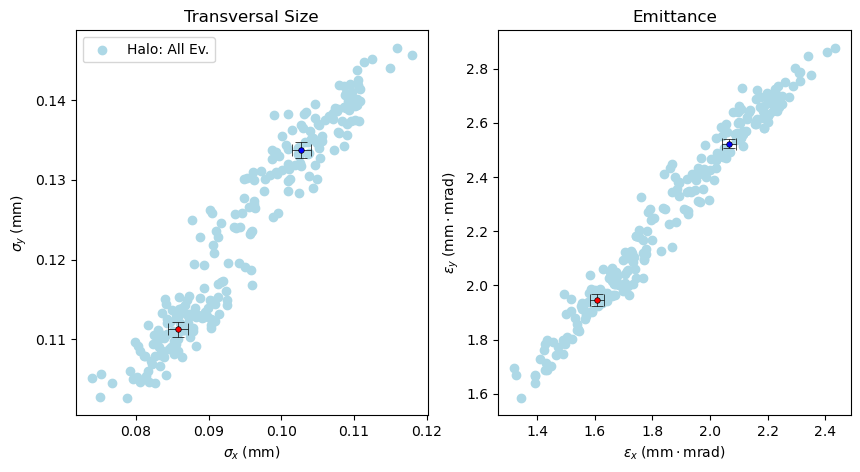

PyObject <matplotlib.legend.Legend object at 0x7f937533c760>

In [20]:
fig, ax= plt.subplots(1,2, figsize=(10,5))

ax[1].scatter(summary_data.μx_trsz, summary_data.μy_trsz, color="lightblue", label="Halo: All Ev.")
ax[2].scatter(summary_data.μx_emitt, summary_data.μy_emitt, color="lightblue")


ax[1].errorbar(
    mean_event_sp.μx_trsz, 
    mean_event_sp.μy_trsz,
    xerr=mean_event_sp.σx_trsz,
    yerr=mean_event_sp.σy_trsz,
    color="k", 
    fmt="o", markersize=4,  markeredgewidth=0.5,
    mfc="red", capsize=4, ecolor="k", elinewidth=0.5)

ax[1].errorbar(
    mean_event_lp.μx_trsz, 
    mean_event_lp.μy_trsz,
    xerr=mean_event_lp.σx_trsz,
    yerr=mean_event_lp.σy_trsz,
    color="k", 
    fmt="o", markersize=4,  markeredgewidth=0.5,
    mfc="blue", capsize=4, ecolor="k", elinewidth=0.5)

ax[2].errorbar(
    mean_event_sp.μx_emitt, 
    mean_event_sp.μy_emitt,
    xerr=mean_event_sp.σx_emitt,
    yerr=mean_event_sp.σy_emitt,
    color="k", 
    fmt="o", markersize=4,  markeredgewidth=0.5,
    mfc="red", capsize=4, ecolor="k", elinewidth=0.5, label="Small Pop.:Mean Ev. ")

ax[2].errorbar(
    mean_event_lp.μx_emitt, 
    mean_event_lp.μy_emitt,
    xerr=mean_event_lp.σx_emitt,
    yerr=mean_event_lp.σy_emitt,
    color="k", 
    fmt="o", markersize=4,  markeredgewidth=0.5,
    mfc="blue", capsize=4, ecolor="k", elinewidth=0.5, label="Small Pop.:Mean Ev. ")


ax[1].set_title("Transversal Size")
ax[2].set_title("Emittance")

ax[1].set_xlabel(L"\sigma_x \; (\mathrm{mm})")
ax[1].set_ylabel(L"\sigma_y \; (\mathrm{mm})")

ax[2].set_xlabel(L"\epsilon_x \; (\mathrm{mm \cdot mrad})")
ax[2].set_ylabel(L"\epsilon_y \; (\mathrm{mm \cdot mrad})")

ax[1].legend()

In [21]:
# using DataFrames, CSV

# df = DataFrame(summary_data)
# df_sp = DataFrame(mean_event_sp)
# df_lp = DataFrame(mean_event_lp)

# CSV.write("all-events.csv", df)
# CSV.write("sp-mean.csv", df_sp)
# CSV.write("lp-mean.csv", df_lp)